# MNIST Digit Classification with our own Framework

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [64]:
# !rm *.pkl
# !wget https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/data/mnist.pkl.gz
# !gzip -d mnist.pkl.gz

In [65]:
%matplotlib widget
from sklearn.decomposition import PCA
import OwnFramework as OwnNN
import matplotlib.pyplot as plt 
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random

import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f, encoding='latin1')

In [66]:
labels = MNIST[0][1]
data = MNIST[0][0]

Let's see what is the shape of data that we have:

In [67]:
data.shape

(50000, 784)

### Splitting the Data

We will use Scikit Learn to split the data between training and test dataset:

In [68]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(data,labels,test_size=0.2)
train_x = features_train
train_labels = labels_train
test_x = features_test
test_labels = labels_test

print(f"Train samples: {len(features_train)}, test samples: {len(features_test)}")

Train samples: 40000, test samples: 10000


### Instructions

1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module
1. Define and train one-layered perceptron, observing training and validation accuracy during training
1. Try to understand if overfitting took place, and adjust layer parameters to improve accuracy
1. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.
1. Try to answer the following questions:
    - Does the inter-layer activation function affect network performance?
    - Do we need 2- or 3-layered network for this task?
    - Did you experience any problems training the network? Especially as the number of layers increased.
    - How do weights of the network behave during training? You may plot max abs value of weights vs. epoch to understand the relation.

In [69]:
def get_loss_acc(x,y,net,loss=OwnNN.CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc


def train_epoch(net, train_x, train_labels, loss=OwnNN.CrossEntropyLoss(), batch_size=4, lr=0.1):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)

In [70]:
import matplotlib.cm as cm

pca = PCA(n_components=2)

def plot_decision_boundary(net, fig, ax):
    draw_colorbar = True
    # remove previous plot
    # 移除所有绘制的 Line2D 对象
    for collection in ax.collections:
        collection.remove()
        draw_colorbar = False

    train_x_2d = pca.fit_transform(train_x)  # 把高维数据投影到2D
    # plt.scatter(train_x_2d[:, 0], train_x_2d[:, 1], c=train_labels, cmap='jet', alpha=0.5)
    # generate countour grid
    x_min, x_max = train_x_2d[:, 0].min() - 1, train_x_2d[:, 0].max() + 1
    y_min, y_max = train_x_2d[:, 1].min() - 1, train_x_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel().astype('float32'), yy.ravel().astype('float32')]

    # 使用 PCA 的 inverse_transform 将 grid_points 从 2D 恢复到原始的 D 维
    grid_points_original = pca.inverse_transform(grid_points)
    n_classes = max(train_labels)+1
    # while train_x.shape[1] > grid_points.shape[1]:
    #     # pad dimensions (plot only the first two)
    #     grid_points = np.c_[grid_points,
    #                         np.empty(len(xx.ravel())).astype('float32')]
    #     grid_points[:, -1].fill(train_x_2d[:, grid_points.shape[1]-1].mean())

    # evaluate predictions
    prediction = np.array(net.forward(grid_points_original))
    # for two classes: prediction difference
    if (n_classes == 2):
        Z = np.array([0.5+(p[0]-p[1])/2.0 for p in prediction]).reshape(xx.shape)
    else:
        Z = np.array([p.argsort()[-1]/float(n_classes-1) for p in prediction]).reshape(xx.shape)
    
    # draw contour
    levels = np.linspace(0, 1, 40)
    cs = ax.contourf(xx, yy, Z, alpha=0.4, levels = levels)
    if draw_colorbar:
        fig.colorbar(cs, ax=ax, ticks = [0, 0.5, 1])
    c_map = [cm.jet(x) for x in np.linspace(0.0, 1.0, n_classes) ]
    colors = [c_map[l] for l in train_labels]
    ax.scatter(train_x_2d[:, 0], train_x_2d[:, 1], marker='o', c=colors, s=60, alpha = 0.5)
    
def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # remove previous plot
    # 移除所有绘制的 Line2D 对象
    for line in ax.lines:
        line.remove()

    # draw updated lines
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
        print('training accuracy: {}, validation accuracy: {}'.format(y_data[i][0], y_data[i][1]))
    ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
              loc='upper center', ncol = 2)
    
def train_and_plot(n_epoch, net, loss=OwnNN.CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(2, 1)
    ax[0].set_xlim(0, n_epoch + 1)
    ax[0].set_ylim(0,1)

    train_acc = np.empty((n_epoch, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch, 3))
    valid_acc[:] = np.NAN

    for epoch in range(1, n_epoch + 1):

        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(train_x,train_labels, net, loss)
        train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(test_x,test_labels, net, loss)
        valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
        # print(train_acc.shape)
        
        ax[0].set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax[0])
        plot_decision_boundary(net, fig, ax[1])
        fig.canvas.draw()
        fig.canvas.flush_events()
        # plt.show()

    return train_acc, valid_acc

In [71]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

training accuracy: 0.8928, validation accuracy: nan
training accuracy: 0.8907, validation accuracy: nan
training accuracy: 0.8928, validation accuracy: 0.9025
training accuracy: 0.8907, validation accuracy: 0.9002
training accuracy: 0.8928, validation accuracy: 0.9025
training accuracy: 0.8907, validation accuracy: 0.9002
training accuracy: 0.8928, validation accuracy: 0.9025
training accuracy: 0.8907, validation accuracy: 0.9002
training accuracy: 0.8928, validation accuracy: 0.9025
training accuracy: 0.8907, validation accuracy: 0.9002
training accuracy: 0.8928, validation accuracy: 0.9025
training accuracy: 0.8907, validation accuracy: 0.9002
training accuracy: 0.8928, validation accuracy: 0.9025
training accuracy: 0.8907, validation accuracy: 0.9002
training accuracy: 0.8928, validation accuracy: 0.9025
training accuracy: 0.8907, validation accuracy: 0.9002
training accuracy: 0.8928, validation accuracy: 0.9025
training accuracy: 0.8907, validation accuracy: 0.9002
training accurac

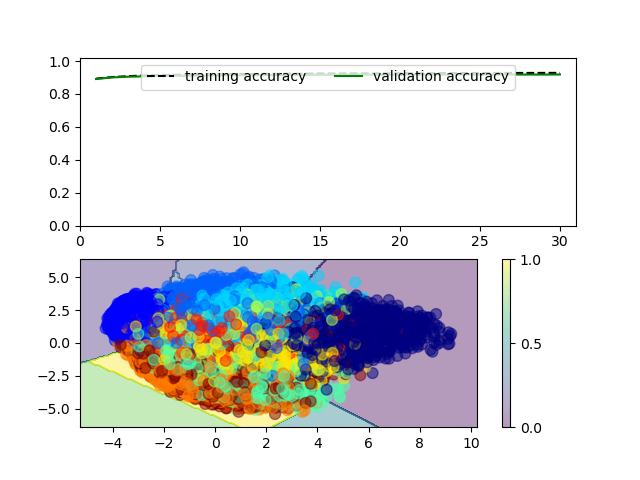

In [74]:

net = OwnNN.Net()
net.add(OwnNN.Linear(train_x.shape[1], max(train_labels)+1))
net.add(OwnNN.Softmax())
res = train_and_plot(30,net,lr=0.005)

# print(train_x.shape)
# print(train_labels.shape)

training accuracy: 0.9282, validation accuracy: nan
training accuracy: 0.9224, validation accuracy: nan
training accuracy: 0.9282, validation accuracy: 0.949
training accuracy: 0.9224, validation accuracy: 0.9408
training accuracy: 0.9282, validation accuracy: 0.949
training accuracy: 0.9224, validation accuracy: 0.9408
training accuracy: 0.9282, validation accuracy: 0.949
training accuracy: 0.9224, validation accuracy: 0.9408
training accuracy: 0.9282, validation accuracy: 0.949
training accuracy: 0.9224, validation accuracy: 0.9408
training accuracy: 0.9282, validation accuracy: 0.949
training accuracy: 0.9224, validation accuracy: 0.9408
training accuracy: 0.9282, validation accuracy: 0.949
training accuracy: 0.9224, validation accuracy: 0.9408
training accuracy: 0.9282, validation accuracy: 0.949
training accuracy: 0.9224, validation accuracy: 0.9408
training accuracy: 0.9282, validation accuracy: 0.949
training accuracy: 0.9224, validation accuracy: 0.9408
training accuracy: 0.928

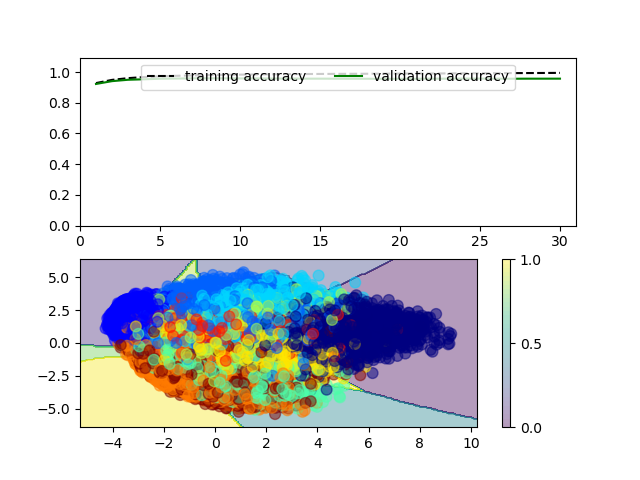

In [ ]:
# net = OwnNN.Net()
# net.add(OwnNN.Linear(train_x.shape[1], 32))
# net.add(OwnNN.Tanh())
# net.add(OwnNN.Linear(32, 32))
# net.add(OwnNN.Tanh())
# net.add(OwnNN.Linear(32, max(train_labels)+1))
# net.add(OwnNN.Softmax())
# res = train_and_plot(30,net,lr=0.01)

# print(train_x.shape)